In [3]:
# importation des libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


In [5]:
base_dir='/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

Train:
Pneumonie: 3875
Normal: 1341



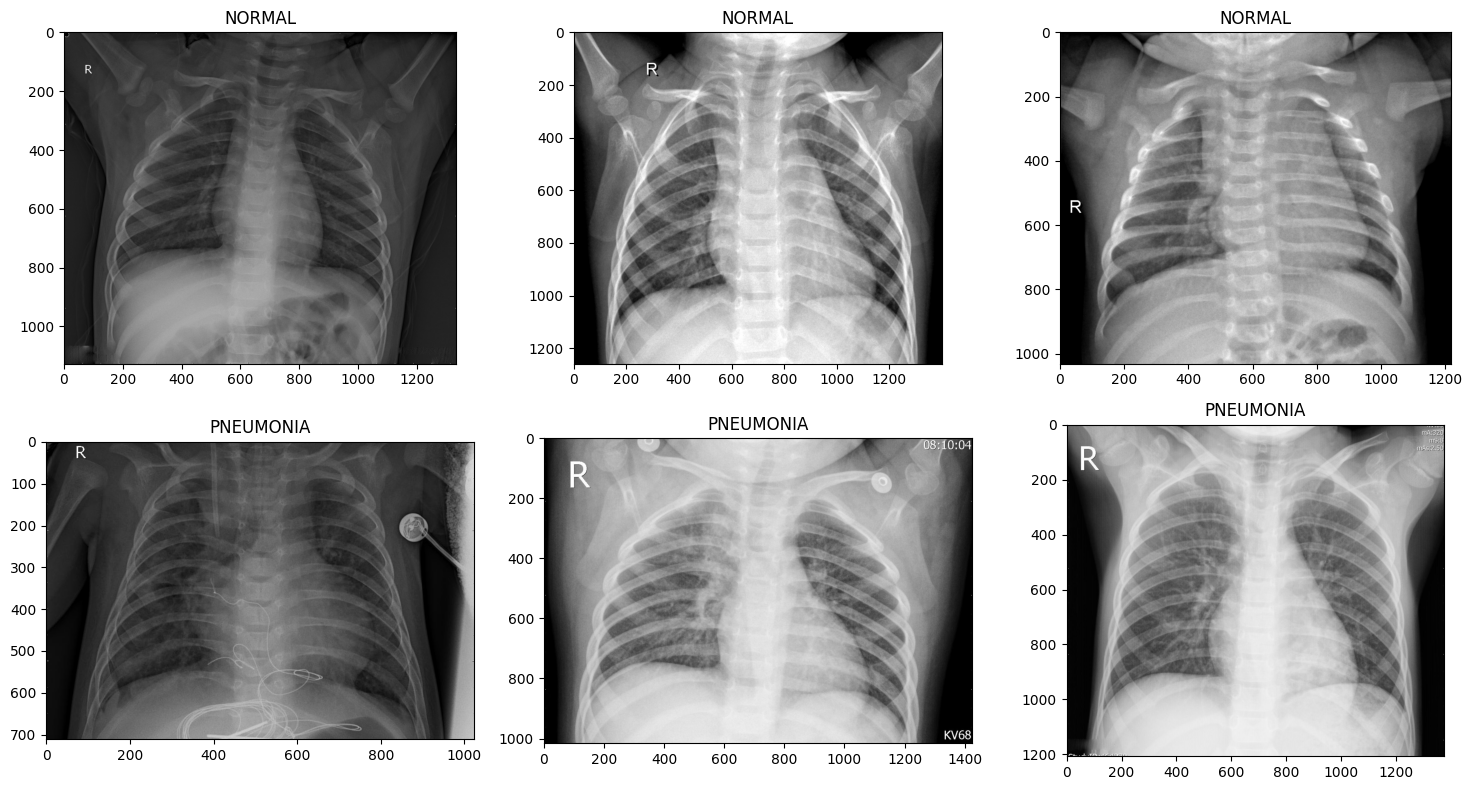

In [6]:
# Comptage des images
print("Train:")
print(f"Pneumonie: {len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))}")
print(f"Normal: {len(os.listdir(os.path.join(train_dir, 'NORMAL')))}\n")

# Visualisation d'exemples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, cls in enumerate(['NORMAL', 'PNEUMONIA']):
    for j in range(3):
        img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[j])
        img = cv2.imread(img_path)
        axes[i,j].imshow(img, cmap='gray')
        axes[i,j].set_title(cls)
plt.tight_layout()

In [7]:
# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
# Chargement de VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Gel des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajout de couches personnalisées
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Entrainement du model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 772ms/step - accuracy: 0.6602 - loss: 0.6352 - val_accuracy: 0.5000 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 540ms/step - accuracy: 0.7671 - loss: 0.4790 - val_accuracy: 0.5625 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 532ms/step - accuracy: 0.8184 - loss: 0.3949 - val_accuracy: 0.5625 - val_loss: 0.6073 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6073 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 546ms/step - accuracy: 0.8538 - loss: 0.3396 - val_accuracy: 0.7500 - val_loss: 0.5675 - learning_rate: 1.0000e-04
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s

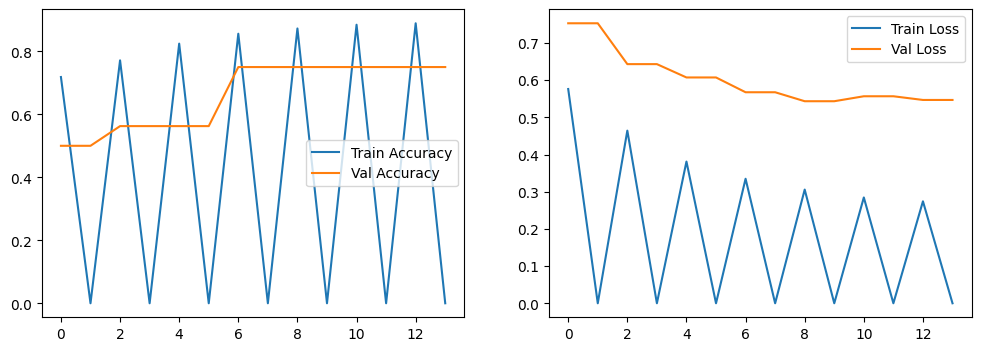

In [10]:
# Visualisation des performances
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [11]:
# Évaluation sur le test set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred))

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       234
           1       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



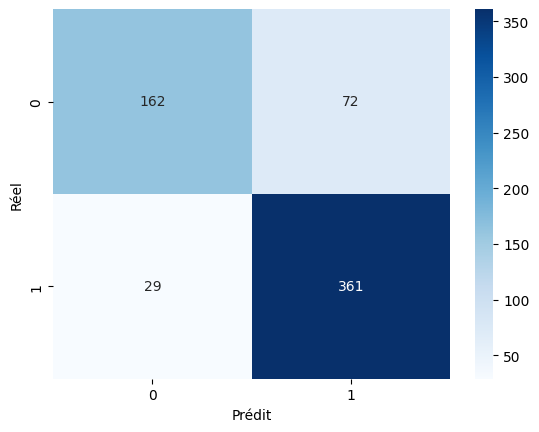

In [12]:
# Matrice de confusion
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [13]:
def predict_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    diagnosis = "PNEUMONIA" if pred[0][0] > 0.5 else "NORMAL"
    
    plt.imshow(img[0])
    plt.title(f"Prédiction: {diagnosis} ({pred[0][0]:.2f})")
    plt.axis('off')
    return diagnosis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'PNEUMONIA'

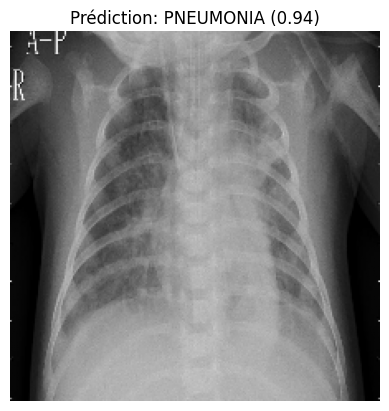

In [19]:
# predict_image('/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')
#predict_image('/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg')
predict_image('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg')